In [1]:
from src.data_preparation.data_preparation import read_eeg_file
from scipy import signal
from scipy import linalg
import pyriemann.utils.mean as rie_mean
import numpy as np
import matplotlib.pyplot as plt

/home/mauricio/development/environments/anaconda3/envs/motor-imagery/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Load some EEG data

In [2]:
FS = 100
TIME_LENGTH = int(FS * 2.5)
TIME_WINDOW = int(FS * 2.5)
DATA_FOLDER = "data/si-bci/bci-iii-dataset-iv-a"
CSP_COMPONENTS = 8

subject = 1
left_data_file = f"{DATA_FOLDER}/left-hand-subject-{subject}.csv"
right_data_file = f"{DATA_FOLDER}/right-hand-subject-{subject}.csv"
data = read_eeg_file(left_data_file, right_data_file, TIME_LENGTH, TIME_WINDOW)

Filter the data with a fifth order Butterworth bandpass filter

In [3]:
sos = signal.butter(5, [8, 30], analog=False, btype="band", output="sos", fs=FS)

data.left_data = signal.sosfilt(sos, data.left_data, axis=1)
data.right_data = signal.sosfilt(sos, data.right_data, axis=1)


Spatially filter the data using the CSP algorithm 

In [4]:
cov_shape = (data.n_channels, data.n_channels)

# Estimate the covariance matrix of every trial
cov = np.zeros((data.n_left_trials, *cov_shape))
for n_trial in range(data.n_left_trials):
    trial = data.left_data[n_trial]
    cov[n_trial] = np.cov(np.transpose(trial))

# calculate average of covariance matrix
cov_1 = rie_mean.mean_covariance(cov, metric="riemann")

# Estimate the covariance matrix of every trial
cov = np.zeros((data.n_right_trials, *cov_shape))
for n_trial in range(data.n_right_trials):
    trial = data.right_data[n_trial]
    cov[n_trial] = np.cov(np.transpose(trial))

# calculate average of covariance matrix
cov_2 = rie_mean.mean_covariance(cov, metric="riemann")

# Solve the generalized eigenvalue problem
n_pairs = CSP_COMPONENTS // 2
w, vr = linalg.eig(cov_1, cov_2, right=True)
w = np.abs(w)
sorted_indexes = np.argsort(w)
chosen_indexes = np.zeros(2 * n_pairs).astype(int)
chosen_indexes[0:n_pairs] = sorted_indexes[0:n_pairs]
chosen_indexes[n_pairs:2 * n_pairs] = sorted_indexes[-n_pairs:]

W = vr[:, chosen_indexes]

data.Z = np.zeros((data.n_trials, CSP_COMPONENTS, data.X.shape[1]))
for n_trial in range(data.n_trials):
    x = data.X[n_trial]
    data.Z[n_trial] = np.dot(np.transpose(W), np.transpose(x))

Generate an array with the Katz Fractal Dimension feature 
      

In [30]:
KFD = np.zeros((data.n_trials, CSP_COMPONENTS))
for n_trial in range(data.n_trials):
    for n_component in range(CSP_COMPONENTS):
        z = data.Z[n_trial, n_component]
        z = signal.sosfilt(sos, z)
        
        N = len(z) - 1
        
        # 1. line-length
        L = np.zeros(N)
        for n in range(N):
            # Use the Euclidean distance formula to obtain the distance between the consecutive points
            x_distance = 1
            y_distance = (z[n]-z[n+1])**2
            L[n] = np.sqrt(x_distance + y_distance)
        L = np.sum(L)
        
        # 2. maximum distance:
        d = np.zeros(N)
        for n in range(N):
            # Use the Euclidean distance formula to obtain the distance between the points to the origin
            x_distance = n**2
            y_distance = (z[0]-z[n+1])**2
            d[n] = np.sqrt(x_distance + y_distance)
        d = np.max(d)

        ln = np.log10(N)
        KFD[n_trial, n_component] = ln / (np.log10(d/L) + ln)

Generate a box plot to visualize the distribution of the Katz Fractal Dimension feature 

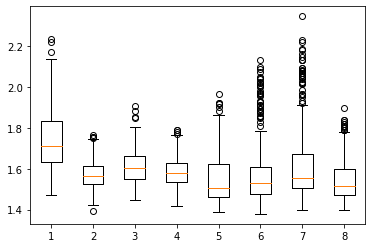

In [31]:
fig, ax = plt.subplots()
ax.boxplot(KFD);
